In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interp
import h5py
import glob
from apply_rfchain import open_gp300, open_horizon, smap_2_tf, noise_sample, compute_noise

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)

In [2]:
latitude = (90-(-35.206667)) * np.pi / 180
latitude = (90-(50)) * np.pi / 180
latitude = (90-(42.2281)) * np.pi / 180

LST_hours = np.arange(1,24,0.5)
LST_radians = LST_hours * 15 * np.pi / 180
target_freqs = np.fft.rfftfreq(8192, 1/2e9)


In [3]:
path_to_GP300_EW = "/volatile/home/af274537/Documents/WorkingDir/grand/data/detector/Light_GP300Antenna_EWarm_leff.npz"
path_to_GP300_SN = "/volatile/home/af274537/Documents/WorkingDir/grand/data/detector/Light_GP300Antenna_SNarm_leff.npz"
path_to_GP300_Z = "/volatile/home/af274537/Documents/WorkingDir/grand/data/detector/Light_GP300Antenna_Zarm_leff.npz"
t_EW = open_gp300(path_to_GP300_EW)
t_SN = open_gp300(path_to_GP300_SN)
t_Z = open_gp300(path_to_GP300_Z)

In [4]:
balun1      = np.loadtxt("./electronics/balun_in_nut.s2p", comments=['#', '!']).astype(np.float64)
matchnet_sn = np.loadtxt("./electronics/MatchingNetworkX.s2p", comments=['#', '!']).astype(np.float64)
matchnet_ew = np.loadtxt("./electronics/MatchingNetworkY.s2p", comments=['#', '!']).astype(np.float64)
matchnet_z  = np.loadtxt("./electronics/MatchingNetworkZ.s2p", comments=['#', '!']).astype(np.float64)
LNA_sn      = np.loadtxt("./electronics/LNA-X.s2p", comments=['#', '!']).astype(np.float64)
LNA_ew      = np.loadtxt("./electronics/LNA-Y.s2p", comments=['#', '!']).astype(np.float64)
LNA_z       = np.loadtxt("./electronics/LNA-Z.s2p", comments=['#', '!']).astype(np.float64)
cable       = np.loadtxt("./electronics/cable+Connector.s2p", comments=['#', '!']).astype(np.float64)
vga         = np.loadtxt("./electronics/feb+amfitler+biast.s2p", comments=['#', '!']).astype(np.float64)
balun2      = np.loadtxt("./electronics/balun_before_ad.s2p", comments=['#', '!']).astype(np.float64)
zload_map   = np.loadtxt("./electronics/S_balun_AD.s1p", comments=['#', '!']).astype(np.float64)
zant_map    = np.loadtxt("./electronics/Z_ant_3.2m.csv", delimiter=",", comments=['#', '!'], skiprows=1).astype(np.float64)

list_s_maps_sn = [balun1, matchnet_sn, LNA_sn, cable, vga]
list_s_maps_ew = [balun1, matchnet_ew, LNA_ew, cable, vga]
list_s_maps_z = [balun1, matchnet_z, LNA_z, cable, vga]
is_db = [False, False, True, True, True]

tf_sn = smap_2_tf(list_s_maps_sn, zload_map, zant_map, target_freqs, is_db=is_db, balun_2_map=balun2, axis=0)
tf_ew = smap_2_tf(list_s_maps_ew, zload_map, zant_map, target_freqs, is_db=is_db, balun_2_map=balun2, axis=1)
tf_z = smap_2_tf(list_s_maps_z, zload_map, zant_map, target_freqs, is_db=is_db, balun_2_map=balun2, axis=2)
tf = np.stack([tf_sn, tf_ew, tf_z])

In [5]:
noise_computer = compute_noise(LST_radians, latitude, 
                              [f"EXPLORATION/LFmap/LFmapshort{i}.npy" for i in range(20, 251)], np.arange(20,251)*1e6,
                              leff_x=t_SN, leff_y=t_EW, leff_z=t_Z)

250000000.0 250000000.0
3.488620044104216
3.3754791163762943
4.807996405910927


In [6]:
noise_computer.noise_power()

Calculating noise power for LST 1.00 hours
Calculating noise power for LST 1.50 hours
Calculating noise power for LST 2.00 hours
Calculating noise power for LST 2.50 hours
Calculating noise power for LST 3.00 hours
Calculating noise power for LST 3.50 hours
Calculating noise power for LST 4.00 hours
Calculating noise power for LST 4.50 hours
Calculating noise power for LST 5.00 hours
Calculating noise power for LST 5.50 hours
Calculating noise power for LST 6.00 hours
Calculating noise power for LST 6.50 hours
Calculating noise power for LST 7.00 hours
Calculating noise power for LST 7.50 hours
Calculating noise power for LST 8.00 hours
Calculating noise power for LST 8.50 hours
Calculating noise power for LST 9.00 hours
Calculating noise power for LST 9.50 hours
Calculating noise power for LST 10.00 hours
Calculating noise power for LST 10.50 hours
Calculating noise power for LST 11.00 hours
Calculating noise power for LST 11.50 hours
Calculating noise power for LST 12.00 hours
Calcul

1.87745083117156e-21

In [7]:
noise_computer.P_nu.max()

1.7552183328671548e-19

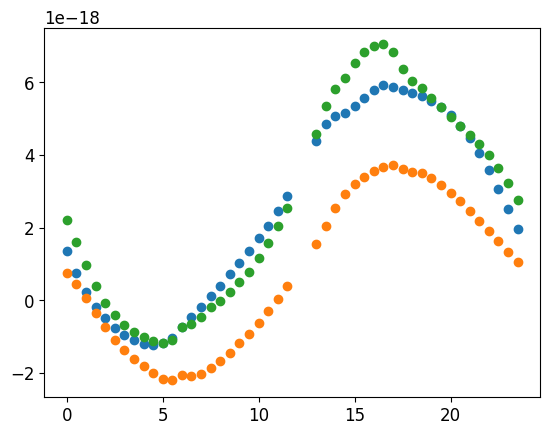

In [16]:
plt.scatter((noise_computer.lst_rads*180/np.pi/15+12)%24, np.sum(noise_computer.P_nu, axis=-1)[:,0], label="Total noise")
plt.scatter((noise_computer.lst_rads*180/np.pi/15+12)%24, np.sum(noise_computer.P_nu, axis=-1)[:,1], label="Total noise")
plt.scatter((noise_computer.lst_rads*180/np.pi/15+12)%24, np.sum(noise_computer.P_nu, axis=-1)[:,2], label="Total noise")